In [2]:
!pip install crr_labels epigenomic_dataset extra_keras_metrics \
    keras_mixed_sequence keras_bed_sequence ucsc_genomes_downloader \
    cache_decorator[all] minepy MulticoreTSNE &> /dev/null && echo "done"
!pip install -Iv humanize==3.9.0 &> /dev/null && echo "done"
!pip install --upgrade tbb

done
done
Requirement already up-to-date: tbb in /usr/local/lib/python3.7/dist-packages (2021.3.0)


In [3]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
import seaborn as sbn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Retrive epigenomic data

In [4]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 512


aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

apip_X, apip_y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

epigenomes = {
    "promoters": apip_X,
    "enhancers": aeie_X,
}

labels = {
    "promoters": apip_y,
    "enhancers": aeie_y,
}

# Retrive genomic sequence

In [5]:
from ucsc_genomes_downloader import Genome

genome = Genome(
    "hg38",
    cache_directory="/content/drive/MyDrive/bio-data/genomes"
)

genome

Human, Homo sapiens, hg38, 2013-12-11, 25 chromosomes

In [6]:
def to_bed(data: pd.DataFrame) -> pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# Describe dataset

In [ ]:
aeie_X

chrom                              SMAD5  NCOA2  ZNF23  ...  NCOR1  NCOA1  KLF1
chrom chromStart chromEnd  strand                       ...                    
chr10 100006381  100006637 .        0.90   0.90   1.37  ...   2.38   0.82  0.69
      100008146  100008402 .        0.73   1.06   0.74  ...   3.11   0.49  1.05
      100014418  100014674 .        0.77   0.33   0.53  ...   0.61   0.97  0.96
      100020216  100020472 .        0.87   0.80   0.83  ...   0.57   0.03  1.07
      100043528  100043784 .        0.64   0.53   0.03  ...   1.26   1.73  0.33
...                                  ...    ...    ...  ...    ...    ...   ...
chrY  7520247    7520503   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7724272    7724528   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7770029    7770285   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7796295    7796551   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      8007562    8007818   .        0.00   0.00   0.00  ...   0.00   0.00  0.00

[63285 rows x 429 columns]

In [ ]:
aeie_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63284.000000,63285.000000,63285.000000,63284.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.854204,0.743733,0.831215,0.800811,0.864409,0.804661,1.245513,0.907048,1.021286,1.101227,...,0.929765,0.976732,0.862212,1.429998,0.810822,0.649336,1.008343,1.075286,0.808300,0.942412
std,0.878816,0.334574,0.532511,0.334844,0.581483,0.453880,2.228033,0.464311,4.122830,2.245365,...,0.825980,0.777798,1.610566,2.560798,0.425050,0.509271,1.594609,1.834175,0.520243,0.563087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.460000,0.520000,0.470000,0.590000,0.510000,0.490000,0.310000,0.580000,0.450000,0.000000,...,0.530000,0.480000,0.510000,0.060000,0.510000,0.270000,0.470000,0.450000,0.480000,0.610000
50%,0.720000,0.720000,0.740000,0.780000,0.800000,0.770000,0.690000,0.850000,0.660000,0.530000,...,0.780000,0.820000,0.760000,0.830000,0.770000,0.550000,0.780000,0.770000,0.770000,0.870000
75%,1.030000,0.930000,1.080000,0.980000,1.140000,1.060000,1.350000,1.160000,0.920000,1.280000,...,1.110000,1.260000,1.050000,1.800000,1.060000,0.930000,1.200000,1.200000,1.080000,1.170000
max,35.750000,6.470000,28.540000,7.480000,47.370000,21.400000,68.250000,9.480000,242.180000,64.490000,...,24.170000,11.920000,141.530000,96.300000,5.020000,4.700000,175.740000,111.920000,37.360000,34.320000


In [ ]:
aeie_y

K562
chrom chromStart chromEnd  strand       
chr10 100006381  100006637 .       False
      100008146  100008402 .       False
      100014418  100014674 .       False
      100020216  100020472 .       False
      100043528  100043784 .       False
...                                  ...
chrY  7520247    7520503   .       False
      7724272    7724528   .       False
      7770029    7770285   .       False
      7796295    7796551   .       False
      8007562    8007818   .       False

[63285 rows x 1 columns]

In [ ]:
aeie_y.describe()

,K562
count,63285
unique,2
top,False
freq,62884


In [ ]:
apip_X

chrom                              SMAD5  NCOA2  ZNF23  ...  NCOR1  NCOA1  KLF1
chrom chromStart chromEnd  strand                       ...                    
chr1  628964     629220    +        0.14   1.00   0.19  ...   1.40   1.74  1.59
      629013     629269    +        0.14   0.97   0.20  ...   1.42   1.63  1.21
      629642     629898    +        0.00   0.11   0.11  ...   0.00   0.16  0.09
      629847     630103    +        0.12   1.07   0.91  ...   0.40   0.60  0.88
      629905     630161    +        0.49   1.37   1.02  ...   0.54   0.61  1.15
...                                  ...    ...    ...  ...    ...    ...   ...
chrX  154441877  154442133 +        1.35   0.56   0.46  ...   0.55   0.77  0.72
      154584927  154585183 +        0.00   0.00   0.00  ...   0.00   0.00  0.00
chrY  1452882    1453138   -        0.00   0.00   0.00  ...   0.00   0.00  0.00
      2500959    2501215   -        0.00   0.00   0.00  ...   0.00   0.00  0.00
      14055973   14056229  +        0.00   0.00   0.00  ...   0.00   0.00  0.00

[99881 rows x 429 columns]

In [ ]:
apip_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,STAG1,ZFX,STAT5A,E2F1,H2AFZ,TAL1,NFRKB,HNRNPUL1,SKIL,RBM34,ZBTB11,RBFOX2,ZNF175,GATA2,XRCC3,NFIC,ATF1,ETV6,ZNF444,MEF2D,ZNF700,SMARCA4,NFXL1,HMBOX1,IKZF1,TBX18,IRF2,H3K27ac,ZKSCAN8,PATZ1,...,ZEB2,KLF10,EP300,HDAC1,CEBPB,H3K4me1,ZNF319,SMARCE1,CBFA2T3,ZNF134,RUNX1,RNF2,TEAD1,MYC,ZNF148,ZNF766,HES1,MCM5,ZNF589,TARDBP,KLF6,ZNF583,ZNF696,PTRF,RFX5,UBTF,TEAD2,SMARCA5,HLTF,ZNF384,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,...,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99878.000000,99880.000000,99881.000000,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000
mean,2.238571,0.657735,0.879565,0.860949,1.241882,0.831541,3.811772,1.017048,8.070131,6.555876,0.976575,1.959957,1.017935,2.145832,3.344470,0.979175,1.059897,0.858909,1.332160,0.858641,1.982076,18.188252,1.025136,1.181866,0.602454,1.054475,2.548241,1.225200,1.038636,0.978174,0.824844,1.394838,0.719602,1.014631,1.476573,1.191939,1.998594,6.426394,0.792813,0.828747,...,1.174634,0.714006,2.543925,2.311955,1.466023,2.757002,0.941435,1.203866,1.156695,1.029025,1.184694,1.002262,1.281487,6.448499,1.246665,1.023517,0.987374,0.653888,0.985080,1.699611,1.190871,1.297463,0.726571,0.625108,1.448499,1.933716,0.689585,0.820417,0.970484,2.557901,2.409723,0.981741,1.510206,7.417156,0.797512,0.601236,2.889943,1.165788,0.699335,1.298927
std,2.650387,0.930009,0.589551,0.391718,2.192965,1.723633,5.233189,0.522413,23.177855,10.750923,0.608962,2.603050,0.922656,7.960317,4.159983,2.878788,1.202379,0.588231,1.019596,0.711274,7.306638,29.033829,0.747003,1.114704,0.301215,1.814821,5.564565,1.168604,0.846605,1.013453,0.663987,1.127938,1.076045,1.239452,2.218615,0.761275,3.398458,12.257666,0.440309,0.477820,...,1.806582,0.387256,3.717899,2.321353,2.725362,3.447861,1.642219,1.026821,4.449550,0.899171,0.550475,0.654353,1.267255,10.231296,1.359575,0.704527,1.060260,0.419132,0.650312,1.181799,0.995305,0.819610,0.556753,0.442074,4.389313,2.337043,0.546072,0.546032,0.595390,5.807639,2.873567,0.686464,6.726482,13.299242,0.500373,0.441843,16.807033,1.482469,0.462811,1.111308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.620000,0.410000,0.460000,0.620000,0.560000,0.390000,0.760000,0.650000,0.570000,0.450000,0.580000,0.600000,0.530000,0.320000,0.490000,0.430000,0.520000,0.440000,0.660000,0.350000,0.700000,0.360000,0.530000,0.680000,0.400000,0.550000,0.710000,0.690000

In [ ]:
apip_y

K562
chrom chromStart chromEnd  strand       
chr1  628964     629220    +       False
      629013     629269    +       False
      629642     629898    +       False
      629847     630103    +       False
      629905     630161    +        True
...                                  ...
chrX  154441877  154442133 +       False
      154584927  154585183 +       False
chrY  1452882    1453138   -       False
      2500959    2501215   -       False
      14055973   14056229  +       False

[99881 rows x 1 columns]

In [ ]:
apip_y.describe()

,K562
count,99881
unique,2
top,False
freq,78250


## Feature sample ratio

In [ ]:
for region, X in epigenomes.items():
    print(f"Feature sample ratio for {region} = {X.shape[0] / X.shape[1]}")

Feature sample ratio for promoters = 232.82284382284382
Feature sample ratio for enhancers = 147.5174825174825


## Nan detection

In [ ]:
for region, X in epigenomes.items():
    print(region)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")
    print("=" * 30)

promoters
Total NaN values: 437/42848949
Max NaN in a row: 20/429
Max NaN in a feature: 191/99881
enhancers
Total NaN values: 71/27149265
Max NaN in a row: 7/429
Max NaN in a feature: 62/63285


## Class balance

First, it is necessary to tranform boolean values into 0 and 1.

In [7]:
def binarize(y: pd.DataFrame,
             cell_line: str)-> pd.DataFrame:
    return y[cell_line].astype(int)

In [8]:
for region, y in labels.items():
    labels[region][cell_line] = binarize(y, cell_line)

Active-Inactive promoters ratio: 0.2764345047923323
Active fraction in promoters: 0.21656771558154203
Active-Inactive enhancers ratio: 0.006376820812925387
Active fraction in enhancers: 0.006336414632219325


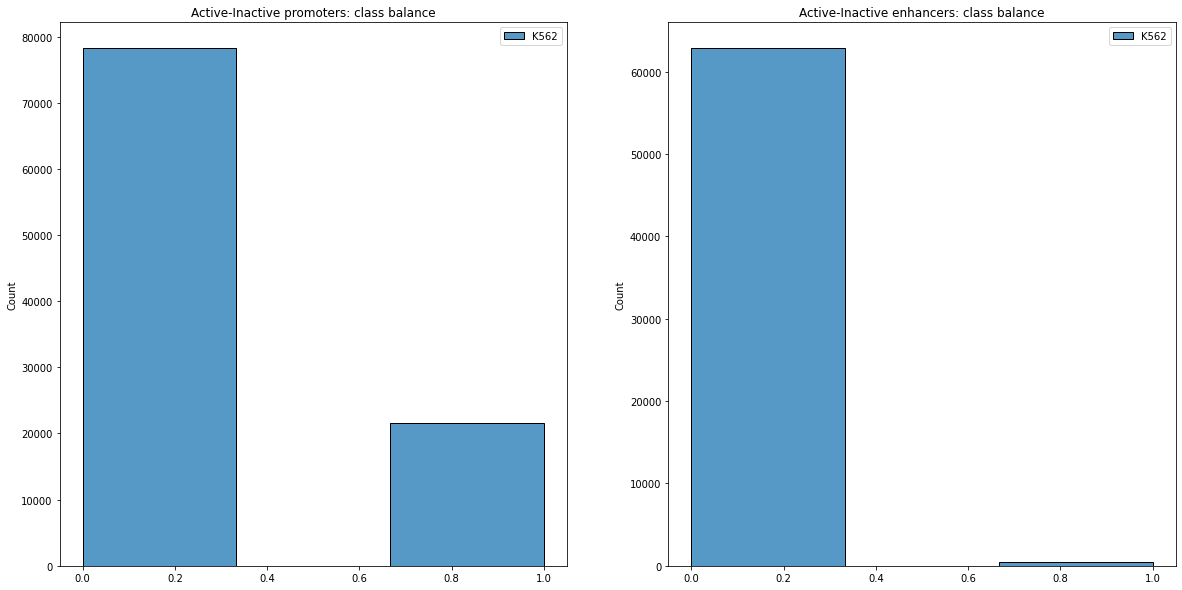

In [ ]:
_, axs = plt.subplots(ncols=2, figsize=(20, 10))
for i, (region, y) in enumerate(labels.items()):
    axes = sbn.histplot(
        data=y,
        bins=3,
        ax=axs[i],
    )

    axes.set_title(f"Active-Inactive {region}: class balance")
    counts = y[cell_line].value_counts()
    print(f"Active-Inactive {region} ratio: {counts[1]/counts[0]}")
    print(f"Active fraction in {region}: {counts[1]/(counts[0]+counts[1])}")

# Data preprocessing

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler

def build_preprocess_pipeline() -> Pipeline:
    return Pipeline([
        ("drop_costant_feature", VarianceThreshold()),
        ("impute", SimpleImputer(strategy="median")),
        ("scale", RobustScaler()),
    ])

# Verify output correlation

In [ ]:
from scipy.stats import pearsonr
from typing import Set

def pearson_corr_output(X: pd.DataFrame,
                        y: np.ndarray,
                        region: str,
                        p_value_threshold: float = 0.01) -> Set:
    uncorrelated_features_with_output = set()

    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [ ]:
from scipy.stats import spearmanr


def spearman_corr_output(
    X: pd.DataFrame,
    y: np.ndarray,
    region: str,
    p_value_threshold: float = 0.01,
) -> Set:
    uncorrelated_features_with_output = set()
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [ ]:
from minepy import MINE
from typing import Dict

#@Cache(
    # cache_path="/content/drive/MyDrive/bio-data/outcorr/mine/{region}/{_hash}.pkl.gz",
    # args_to_ignore=["X", "y", "uncorrelated_features"]
# )
def mic_corr_output(
    X: pd.DataFrame,
    y: np.ndarray,
    region: str,
    uncorrelated_features: Dict,
    score_threshold: float = 0.05,
) -> Dict:
    for feature in tqdm(
        uncorrelated_features[region],
        desc = f"Running MINE test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        mine = MINE()
        mine.compute_score(
            X[feature].values.ravel(),
            y
        )
        score = mine.mic()
        if score >= score_threshold:
            print(f"{feature} is not correlated for")
            uncorrelated_features[region].remove(feature)

    return uncorrelated_features

In [ ]:
uncorrelated_features_with_output = {
    region: set()
    for region in epigenomes.keys()
}

for region, X in epigenomes.items():
    uncorrelated_features_with_output[region] = pearson_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )
    uncorrelated_features_with_output[region] = spearman_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )

print(f"The following features have no correlation with the output: {uncorrelated_features_with_output}")

The following features have no correlation with the output: {'promoters': {'THRAP3', 'NCOA4'}, 'enhancers': {'H3K36me3', 'XRCC3', 'SRSF7', 'ZNF318', 'SNRNP70', 'ZNF830', 'THRA', 'SAFB2', 'U2AF2', 'STAG1', 'RBM17', 'ZKSCAN3', 'NFE2L1', 'HNRNPH1', 'RBM34', 'ZNF408', 'FOXJ3', 'ILK', 'ZNF280A', 'whole-genome shotgun bisulfite sequencing', 'ZNF778', 'DLX4', 'FOXA1', 'MCM7', 'RBM15', 'PCBP2', 'ZBTB8A'}}


In [ ]:
for region, X in epigenomes.items():
    uncorrelated_features_with_output = mic_corr_output(
        X,
        labels[region].values.ravel(),
        region,
        uncorrelated_features_with_output,
    )

In [ ]:
for region, X in epigenomes.items():
    last_shape = X.shape
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])
    print(f"{region} now has shape {epigenomes[region].shape} (last was {last_shape})")

promoters now has shape (99881, 427) (last was (99881, 429))
enhancers now has shape (63285, 402) (last was (63285, 429))


# Feature Correlation

In [ ]:
from scipy.stats import entropy
from typing import List

# TODO
# - cache this method
# - remove thresholds
def features_correlation(
    X: pd.DataFrame,
    region: str,
    p_value_threshold: float = 0.01,
    correlation_threshold: float = 0.95
) -> List:
    scores = []

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores.append((correlation, p_value, feature_1, feature_2))
    #        if p_value < p_value_threshold and np.abs(correlation) > correlation_threshold:
    #            print(f"High correlation (Pearson): {feature_1} with {feature_2} ({correlation})")
    #            if entropy(X[feature_1]) > entropy(X[feature_2]):
    #                high_correlation[region].add(feature_2)
    #            else:
    #                high_correlation[region].add(feature_1)
    
    return scores

In [ ]:
feature_corr_scores = {
    region: list()
    for region in epigenomes.keys()
}

for region, X in epigenomes.items():
    feature_corr_scores[region] = features_correlation(X, region)

Running tests for promoters:   0%|          | 0/427 [00:00<?, ?it/s]

Running tests for enhancers:   0%|          | 0/402 [00:00<?, ?it/s]

In [ ]:
# sort features by decreasing correlation

feature_corr_scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in feature_corr_scores.items()
}

Most correlated features from promoters
Most correlated features from enhancers


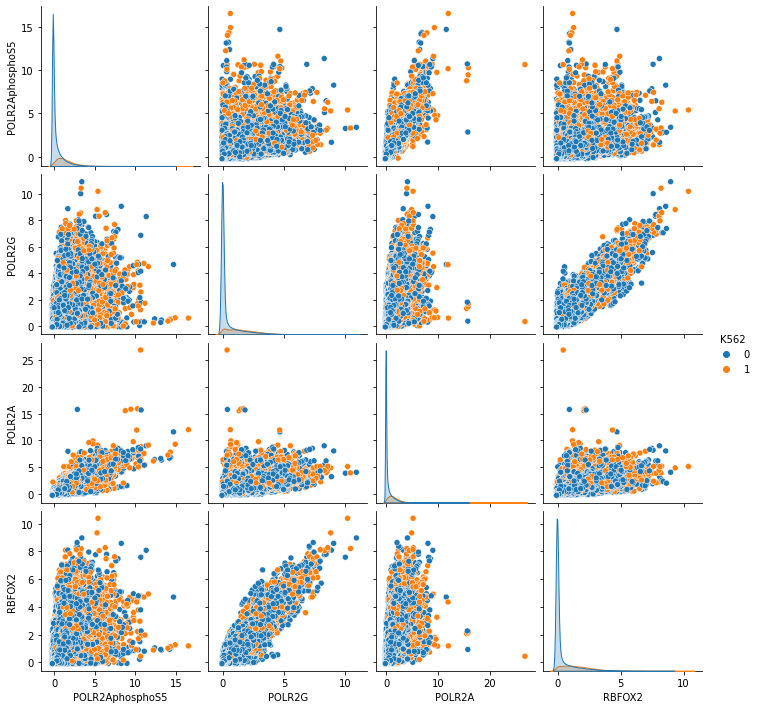

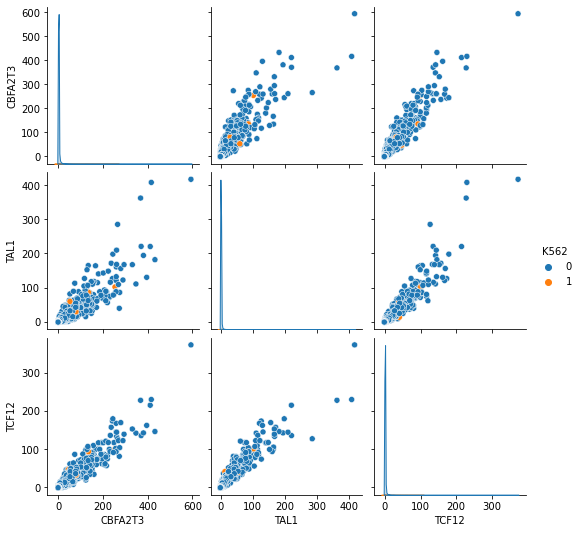

In [ ]:
for region, X in epigenomes.items():
    # take the first two elems and extract the first two columns
    _, _, firsts, seconds = list(zip(*feature_corr_scores[region][:2]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region}")
    sbn.pairplot(
        pd.concat([
            X[columns],
            labels[region],
        ], axis=1),
        hue=labels[region].columns[0],
    )

In [ ]:
correlation_threshold = 0.95
p_value_threshold = 0.01

for region, X in epigenomes.items():
    last_shape = X.shape
    high_correlation = [
        (item[2], item[3])
        for item in feature_corr_scores[region]
        if item[0] > correlation_threshold and item[1] < p_value_threshold
    ]
    to_drop = []
    for f1, f2 in high_correlation:
        if entropy(X[f1]) > entropy(X[f2]):
            to_drop.append(f2)
        else:
            to_drop.append(f1)
    epigenomes[region] = X.drop(
        to_drop,
        axis=1
    )
    print(f"Dropping {to_drop} from {region} dataset...")
    print(f"New shape: {epigenomes[region].shape} (was {last_shape})")

Dropping ['RBFOX2'] from promoters dataset...
New shape: (99881, 426) (was (99881, 427))
Dropping ['TCF12'] from enhancers dataset...
New shape: (63285, 401) (was (63285, 402))


# Feature selection

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE
from multiprocess import cpu_count

def recursive_feature_elimination_with_sgd(X: pd.DataFrame,
                                           y: np.ndarray,
                                           region: str,
                                           n_features: int = 50,
                                           deletion_step: int = 10,
                                           verbose: int = 0)-> pd.DataFrame:
    clf = SGDClassifier(
        loss="log",
        penalty="l1",
        #verbose=1,
        n_jobs=cpu_count(),
        early_stopping=True,
        class_weight="balanced",
    )
    rfe = RFE(
        clf,
        n_features_to_select=n_features,
        step=deletion_step,
        verbose=verbose,
    )
    rfe = rfe.fit(X, y)
    X_new = pd.DataFrame(
        rfe.transform(X),
        columns=X.columns[rfe.get_support()],
        index=X.index,
    )
    return X_new

# Data visualization

In [ ]:
from sklearn.decomposition import PCA

def pca_decomposition(X: np.ndarray, components: int = 2) -> np.ndarray:
    return PCA(n_components=components).fit_transform(X)

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE

@Cache(
    cache_path="decomposition/tsne/{task}/{perplexity}_{dimensionality_threshold}_{_hash}.pkl.gz",
    args_to_ignore=["X"]
)
def tsne_decomposition(X:np.ndarray,
                       perplexity:int,
                       task:str,
                       dimensionality_threshold:int=50) -> np.ndarray:
    if X.shape[1] > dimensionality_threshold:
        X = pca_decomposition(X, components=dimensionality_threshold)
    return TSNE(
        perplexity=perplexity,
        n_jobs=cpu_count(),
        random_state=42
    ).fit_transform(X)

In [ ]:
_, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 10)
)

for i, (region, X) in enumerate(epigenomes.items()):
    pca_dec = pca_decomposition(X.values)
    tsne_dec = tsne_decomposition(
        X.values,
        perplexity=30,
        task=region,
        dimensionality_threshold=50,
    )
    
    ax = sbn.scatterplot(
        x=pca_dec.T[0],
        y=pca_dec.T[1],
        hue=labels[region][cell_line],
        ax=axs[i][0]
    )
    ax.set_title(f"{region}: PCA decomposition")
    
    ax = sbn.scatterplot(
        x=tsne_dec.T[0],
        y=tsne_dec.T[1],
        hue=labels[region][cell_line],
        ax=axs[i][1]
    )
    ax.set_title(f"{region}: TSNE decomposition")
    

# Model evaluation

In [11]:
from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score


def evaluate_model_prediction(y_true: np.ndarray,
                              y_pred: np.ndarray)-> Dict[str, float]:
    """Returns the evaluation of the given predictions.

    By default, this method evaluates accuracy, AUROC and AUPRC.

    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(
                y_true, 
                np.round(y_pred).astype(int)
            )
            for metric in int_metrics
        }
    }

In [12]:
def evaluate_all_model_prediction(y_train_true: np.ndarray,
                                  y_train_pred: np.ndarray,
                                  y_test_true: np.ndarray,
                                  y_test_pred: np.ndarray,
                                  model_name: str,
                                  task_name: str,
                                  holdout_number: int,
                                  use_feature_selection: bool,
) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    task_name: str,
        Name of the task to work with.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features selection or not.

    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "task_name": task_name,
        "holdout_number": holdout_number,
        "use_feature_selection": use_feature_selection
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations
        },
    ]

In [13]:
from typing import Union
from tensorflow.keras.models import Model
from keras_mixed_sequence import MixedSequence, VectorSequence
from sklearn.ensemble import RandomForestClassifier

@Cache(
    cache_path="/content/drive/MyDrive/bio-data/training/{predictor_name}/{task_name}_{holdout_number}/{use_feature_selection}_{_hash}.csv.gz",
    args_to_ignore=["predictor", "X_train", "X_test", "y_train", "y_test"]
)
def train_random_forest(predictor: RandomForestClassifier,
                        X_train: np.ndarray,
                        y_train: np.ndarray,
                        X_test: np.ndarray,
                        y_test: np.ndarray,
                        task_name: str,
                        predictor_name: str,
                        holdout_number: int,
                        use_feature_selection: bool)-> pd.DataFrame:
    """Trains and evaluates the given predictor.
    
    By defualt, this method evaluates accuracy, AUROC and AUPRC on the test set.

    Args:
        predictor: A sklearn RandomModelClassifier to train.
        X_train: The training set.
        y_train: The labels corresponding to the training set.
        X_test: The test set.
        y_test: The labels corresponding to the test set.
        task_name: The name of the task where the predictor is trained on.
        predictor_name: The name of the predictor.
        holdout_number: The number of the holdout currently taken.
        use_feature_selection: Wheter the predictor is trained on a reduced 
          dataset.

    Returns:
        A dict where the keys are the name of the metrics ("accuracy", "AUROC",
        "AUPRC"), and the values are the respective scores.
    """
    
    predictor.fit(X_train, y_train)

    y_train_prediction = predictor.predict(X_train)
    y_test_prediction = predictor.predict(X_test)
    
    return pd.DataFrame(evaluate_all_model_prediction(
        y_train, y_train_prediction,
        y_test, y_test_prediction,
        predictor_name,
        task_name,
        holdout_number,
        use_feature_selection
    ))

In [14]:
from typing import Tuple

@Cache(
    cache_path="/content/drive/MyDrive/bio-data/training/{model_name}/{task}_{holdout_number}/{use_feature_selection}_{_hash}.csv.gz",
    args_to_ignore=["training_sequence", "model", "test_sequence"]
)
def train_model(model: Model,
                model_name: str,
                task: str,
                training_sequence: MixedSequence,
                test_sequence: MixedSequence,
                holdout_number: int,
                use_feature_selection: bool) -> pd.DataFrame:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    model.fit(
        training_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=1e-2,
                patience=2,
                mode="min",
            ),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            TqdmCallback(verbose=1),
        ]
    )
    
    train_evaluation = dict(zip(model.metrics_names,
                                model.evaluate(training_sequence,
                                               verbose=False)))
    test_evaluation = dict(zip(model.metrics_names,
                               model.evaluate(test_sequence, verbose=False)))
    
    common_informations = {
        "model_name": model_name,
        "task_name": task_name,
        "holdout_number": holdout_number,
        "use_feature_selection": use_feature_selection,
    }
        
    return pd.DataFrame([
        {
            **train_evaluation,
            "run_type": "train",
            **common_informations
        },
        {
            **test_evaluation,
            "run_type": "test",
            **common_informations
        },
    ])

# Model creation

In [15]:
from typing import Tuple, Dict
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer, Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_complete_binary_metrics, get_standard_binary_metrics,get_minimal_multiclass_metrics

from tqdm.keras import TqdmCallback
from keras_bed_sequence import BedSequence

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from multiprocess import cpu_count

def build_random_forest(n_estimators: int = 100,
                        max_depth: int = 5,
                        min_samples_leaf: int = 100,
                        verbose=False,
                        random_state: int = 12345) -> RandomForestClassifier:
    return RandomForestClassifier(
        class_weight="balanced_subsample",
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=cpu_count(),
        verbose=verbose,
        random_state=random_state
    )

## Feed-Forward Neural Network

In [17]:
def build_fixed_ffnn(input_shape: int)-> Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(256, activation="relu")(input_epigenomic_data)
    hidden = Dense(128, activation="relu")(hidden)
    last_hidden_ffnn = Dense(64, activation="relu")(hidden)
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryFixedFFNN"
    )

    ffnn.compile(
        optimizer=SGD(
            learning_rate=0.1
        ),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

## CNN

In [18]:
def build_fixed_cnn(window_size: int) -> Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """

    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(32, kernel_size=4, activation="relu")(hidden)
        #hidden = Dropout(rate=0.1)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
    
    hidden = GlobalAveragePooling1D()(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(32, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.2)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    # input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    # #hidden = Reshape((window_size, 4, 1))(input_sequence_data)
    # hidden = BatchNormalization()(input_sequence_data)
    # hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)

    # for _ in range(2):
    #     hidden = BatchNormalization()(hidden)
    #     hidden = Conv1D(
    #         64,
    #         kernel_size=5,
    #         activation="relu"
    #     )(hidden)
        
    # hidden = MaxPool1D(pool_size=2)(hidden)

    # hidden = Conv1D(
    #         64,
    #         kernel_size=10,
    #         activation="relu"
    #     )(hidden)
    
    # hidden = MaxPool1D(pool_size=2)(hidden)
    
    # hidden = Flatten()(hidden)
    # hidden = Dense(64, activation="relu")(hidden)
    # hidden = Dropout(rate=0.1)(hidden)
    # hidden = Dense(64, activation="relu")(hidden)
    # last_hidden_cnn = Dropout(rate=0.1)(hidden)
    # output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(inputs=input_sequence_data,
                outputs=output_cnn,
                name="BinaryClassificationCNN")

    cnn.compile(optimizer=Nadam(learning_rate=0.002),
                loss="binary_crossentropy",
                metrics=get_minimal_multiclass_metrics())

    return cnn, input_sequence_data, last_hidden_cnn

## Multi Modal Neural Network

In [19]:
from typing import Optional

def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
)-> Model:
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    The created model.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    return mmnn

## Create input sequence

In [20]:
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(X: np.ndarray,
                      y: np.ndarray,
                      batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_cnn_sequence(genome: Genome,
                     bed: pd.DataFrame,
                     y: np.ndarray,
                     batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(genome: Genome,
                      bed: pd.DataFrame,
                      X: np.ndarray,
                      y: np.ndarray,
                      batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

# Train and evaluate the models

First, retrive again the datasets to remove any kind of data leakege.

In [ ]:
aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

apip_X, apip_y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

epigenomes = {
    "promoters": apip_X,
    "enhancers": aeie_X,
}

labels = {
    "promoters": binarize(apip_y, cell_line),
    "enhancers": binarize(aeie_y, cell_line),
}

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 2
test_size = 0.2
random_state = 9012

stratified_split = StratifiedShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

In [ ]:
all_performance_history = {}

preprocess = build_preprocess_pipeline()

for task_name, X in epigenomes.items():
    bed = to_bed(X)
    all_performance_history[task_name] = []
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(stratified_split.split(X, labels[task_name])),
        total=n_splits,
        leave=False,
        desc="Computing holdouts for {}".format(task_name)
    ):
        # train and test set
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = (labels[task_name].iloc[train_indices],
                           labels[task_name].iloc[test_indices])

        train_index = X_train.index
        train_columns = X_train.columns
        test_index = X_test.index
        test_columns = X_test.columns
        X_train = pd.DataFrame(data=preprocess.fit_transform(X_train),
                               index=train_index,
                               columns=train_columns)
        X_test =  pd.DataFrame(data=preprocess.transform(X_test),
                               index=test_index,
                               columns=test_columns)
        y_train = y_train.values.flatten()
        y_test = y_test.values.flatten()

        #if holdout_number == 0: 
        #    cnn.summary()
        #    ffnn.summary()
        #    mmnn1.summary()
        #    mmnn2.summary()
        for feature_selection in (False, True):
            if feature_selection:
                X_train = recursive_feature_elimination_with_sgd(X_train,
                                                                 y_train,
                                                                 task_name,
                                                                 n_features=300)
                X_test = X_test[X_train.columns]
             # creation of the models
            random_forest = build_random_forest(verbose=True)
            ffnn, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(
                X_train.shape[1])
            cnn, input_sequence_data, last_hidden_cnn = build_fixed_cnn(
                X_train.shape[1])
            mmnn1 = build_binary_classification_mmnn(X_train.shape[1], 
                                                     window_size)
            mmnn2 = build_binary_classification_mmnn(
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
            )
            # first train the RandomForset, which has a differnt training 
            # procedure
            performance = train_random_forest(random_forest,
                                              X_train.values,
                                              y_train,
                                              X_test.values,
                                              y_test,
                                              task_name,
                                              "RandomForest",
                                              holdout_number,
                                              feature_selection)
            all_performance_history[task_name].append(performance)

            for predictor, predictor_name, train_seq, test_seq in tqdm(
                ((ffnn,
                  ffnn.name,
                  get_ffnn_sequence(X_train.values, y_train, batch_size=1024),
                  get_ffnn_sequence(X_test.values, y_test, batch_size=1024)),
                 (cnn,
                  cnn.name,
                  get_cnn_sequence(genome, train_bed, y_train, batch_size=1024),
                  get_cnn_sequence(genome, test_bed, y_test, batch_size=1024)),
                (mmnn1,
                 mmnn1.name,
                 get_mmnn_sequence(genome, train_bed, X_train.values, y_train),
                 get_mmnn_sequence(genome, test_bed, X_test.values, y_test)),
                (mmnn2,
                 mmnn2.name,
                 get_mmnn_sequence(genome, train_bed, X_train.values, y_train),
                 get_mmnn_sequence(genome, test_bed, X_test.values, y_test))),
                desc="Training models",
                leave=False
            ):
                performance = train_model(predictor,
                                          predictor_name,
                                          task_name,
                                          train_seq,
                                          test_seq,
                                          holdout_number,
                                          feature_selection)
                all_performance_history[task_name].append(performance)

    all_performance_history[task_name] = pd.concat(
        all_performance_history[task_name])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
from IPython.display import display

for region, X in all_performance_history.items():
    print(region.upper())
    X["accuracy"] = X["accuracy"].fillna(0) + X["Accuracy"].fillna(0)
    display(X)


PROMOTERS


,AUPRC,AUROC,Accuracy,run_type,model_name,task_name,holdout_number,use_feature_selection,loss,accuracy,recall,precision
0,0.475755,0.826345,0.788671,train,RandomForest,promoters,0,False,NaN,0.788671,NaN,NaN
1,0.487735,0.833280,0.797868,test,RandomForest,promoters,0,False,NaN,0.797868,NaN,NaN
0,0.688017,0.903152,NaN,train,BinaryFixedFFNN,promoters,0,False,0.312300,0.847054,0.582722,0.668523
1,0.636849,0.894715,NaN,test,BinaryFixedFFNN,promoters,0,False,0.323417,0.837914,0.558715,0.645222
0,0.442850,0.769548,NaN,train,BinaryClassificationCNN,promoters,0,False,0.451766,0.787520,0.186420,0.526694
1,0.453774,0.778585,NaN,test,BinaryClassificationCNN,promoters,0,False,0.445145,0.790008,0.190245,0.543234
0,0.805196,0.944308,NaN,train,BoostedMMNN,promoters,0,False,0.248746,0.885325,0.716614,0.744358
1,0.669513,0.905311,NaN,test,BoostedMMNN,promoters,0,False,0.310081,0.852330,0.628525,0.669375
0,0.479542,0.828513,0.791675,train,RandomForest,promoters,1,False,NaN,0.791675,NaN,NaN
1,0.472052,0.824437,0.785453,test,RandomForest,promoters,1,False,NaN,0.785453,NaN,NaN


ENHANCERS


,AUPRC,AUROC,Accuracy,run_type,model_name,task_name,holdout_number,use_feature_selection,loss,accuracy,recall,precision
0,0.054076,0.866702,0.925792,train,RandomForest,enhancers,0,False,NaN,0.925792,NaN,NaN
1,0.035606,0.791654,0.919175,test,RandomForest,enhancers,0,False,NaN,0.919175,NaN,NaN
0,0.237564,0.827466,NaN,train,BinaryFixedFFNN,enhancers,0,False,0.030267,0.993976,0.056075,0.900000
1,0.076757,0.760480,NaN,test,BinaryFixedFFNN,enhancers,0,False,0.037449,0.993600,0.012500,0.333333
0,0.013470,0.624479,NaN,train,BinaryClassificationCNN,enhancers,0,False,0.038771,0.993660,0.000000,0.000000
1,0.013775,0.624285,NaN,test,BinaryClassificationCNN,enhancers,0,False,0.038541,0.993679,0.000000,0.000000
0,0.518691,0.981193,NaN,train,BoostedMMNN,enhancers,0,False,0.017678,0.994865,0.314642,0.716312
1,0.120166,0.835331,NaN,test,BoostedMMNN,enhancers,0,False,0.032478,0.991862,0.062500,0.151515
0,0.055840,0.860229,0.931382,train,RandomForest,enhancers,1,False,NaN,0.931382,NaN,NaN
1,0.036229,0.782692,0.926049,test,RandomForest,enhancers,1,False,NaN,0.926049,NaN,NaN


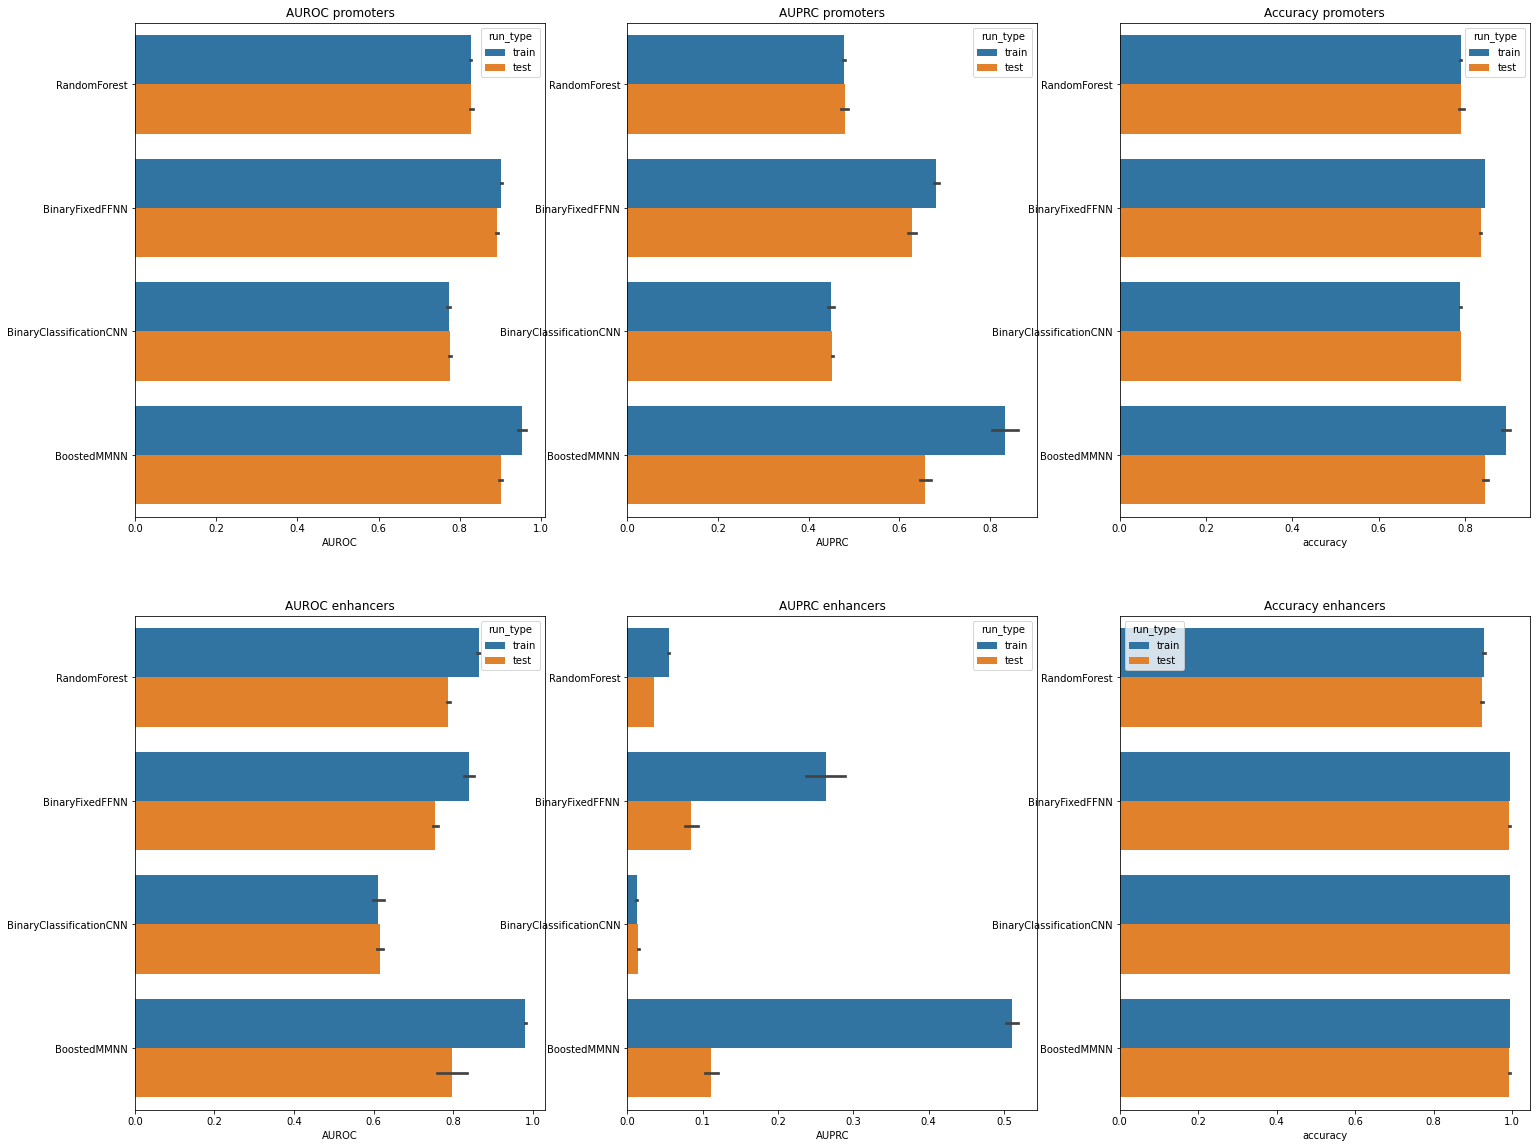

In [ ]:
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 20), squeeze=True)

for i, (task_name, dataframe) in enumerate(all_performance_history.items()):
    sbn.barplot(x="AUROC",
                y="model_name",
                data=dataframe,
                hue="run_type",
                orient="h",
                ax=axs[i][0])
    _ = axs[i][0].set_title(f"AUROC {task_name}")
    axs[i][0].set_ylabel("")
    
    sbn.barplot(x="AUPRC",
                y="model_name",
                data=dataframe,
                hue="run_type",
                orient="h",
                ax=axs[i][1])
    _ = axs[i][1].set_title(f"AUPRC {task_name}")
    axs[i][1].set_ylabel("")
    
    sbn.barplot(x="accuracy",
                y="model_name",
                data=dataframe,
                hue="run_type",
                orient="h",
                ax=axs[i][2])
    _ = axs[i][2].set_title(f"Accuracy {task_name}")
    axs[i][2].set_ylabel("")

# Wilcoxon test

In [ ]:
from scipy.stats import wilcoxon

First, compare the test on the performance of the same model with and without feature selection.

In [ ]:



# test if the models perform better with feature selection or not
for region, X in all_performance_history.items():
    print(region.upper())
    #X["accuracy"] = X["accuracy"].fillna(0) + X["Accuracy"].fillna(0)
    #display(X)
    for model in X.model_name.unique():
        test_performance = X[(X.model_name == model) & (X.run_type == "test")]
        performance_with_feature_selection = test_performance[
            X.use_feature_selection == True
        ]
        performance_without_feature_selection = test_performance[
            X.use_feature_selection == False
        ]

        for metric in ("AUPRC", "AUROC", "accuracy"):
            print(model,
                  metric,
                  wilcoxon(performance_with_feature_selection[metric],
                           performance_without_feature_selection[metric]))

In [ ]:
# comparison between models

for region, X in all_performance_history.items():
    print(region.upper())
    for outer_model in X.model_name.unique():
        outer_model_performance = X[
            (X.model_name == outer_model) &
            (X.run_type == "test")
            # & (X.use_feature_selection == "Feature Selection")
        ]
        for inner_model in X.model_name.unique():
            if outer_model >= inner_model:
                continue
            inner_model_performance = X[
                (X.model_name == inner_model) &
                (X.run_type == "test")
                # & (X.use_feature_selection == "Feature Selection")
            ]

            for metric in ("AUPRC", "AUROC", "accuracy"):
                outer, inner = (outer_model_performance[metric], 
                                inner_model_performance[metric])
                _, p_value = wilcoxon(outer, inner)
                if p_value < 0.01:
                    if outer.mean() > inner.mean():
                        best_model, worse_model = outer_model, model
                    else:
                        best_model, worse_model = model, outer_model
                    print("The model {} outperforms the model {} with p-value {} on metric {}.".format(
                        best_model,
                        worse_model,
                        p_value,
                        metric
                    ))
                else:
                    print("The model {} is statistially indistinguishiable from {} with p-value {} on metric {}.".format(
                        outer_model,
                        model,
                        p_value,
                        metric
                    ))